## M08 Homework

### Michael Vaden, mtv2eva

In [6]:
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk
import plotly_express as px
from lib.textparser import TextParser
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from numpy.linalg import norm
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
import configparser
config = configparser.ConfigParser()
config.read("../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
data_prefix = 'novels'

In [3]:
OHCO = ['book_id','chap_id','para_num','sent_num','token_num']

In [4]:
LIB = pd.read_csv(f"{data_home}/{data_prefix}-LIB.csv").set_index('book_id')
CORPUS = pd.read_csv(f"{data_home}/{data_prefix}-CORPUS.csv").set_index(OHCO)

In [48]:
nouns = ['NN', 'NNS']

CORPUS = CORPUS.query("pos in @nouns")

CORPUS

pos        term_str
book_id         chap_id para_num sent_num token_num                     
secretadversary 1       1        0        2           NN           thing
                        2        0        2           NN            bean
                        3        0        3          NNS          people
                                          7           NN  affectionately
                                          15          NN            exit
...                                                  ...             ...
baskervilles    11      114      0        0           NN              it
                                          10          NN            well
                                          13          NN           voice
                                 1        0          NNS               i
                                          11          NN              in

[311851 rows x 2 columns]

In [49]:
def join_lists_to_sentence(lst):
    return ' '.join(lst)

In [60]:
DOCS = CORPUS.dropna().groupby(OHCO[:3]).term_str.apply(list).to_frame().rename(columns={'term_str':'doc_str'})

DOCS_c = CORPUS.dropna().groupby(OHCO[:2]).term_str.apply(list).to_frame().rename(columns={'term_str':'doc_str'})

In [62]:
DOCS['doc_str'] = DOCS['doc_str'].apply(join_lists_to_sentence)

DOCS_c['doc_str'] = DOCS_c['doc_str'].apply(join_lists_to_sentence)

In [77]:
n_topics = 20
max_iter = 5

lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)
lda_engine_c = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

In [69]:
count_engine = CountVectorizer(max_features= 4000, ngram_range=(1, 2), stop_words='english')
count_model = count_engine.fit_transform(DOCS.doc_str)
TERMS = count_engine.get_feature_names_out()

count_engine_c = CountVectorizer(max_features= 4000, ngram_range=(1, 2), stop_words='english')
count_model_c = count_engine_c.fit_transform(DOCS_c.doc_str)
TERMS_c = count_engine_c.get_feature_names_out()

Theta

### Paragraph Topic Models

In [70]:
TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]

In [71]:
lda_model = lda_engine.fit_transform(count_model)
THETA = pd.DataFrame(lda_model, index=DOCS.index)
THETA.columns.name = 'topic_id'
THETA.columns = TNAMES

In [72]:
THETA

T00       T01       T02       T03       T04  \
book_id    chap_id para_num                                                     
adventures 1       1         0.050000  0.050000  0.050000  0.050000  0.050000   
                   2         0.001563  0.266616  0.001563  0.001563  0.001563   
                   3         0.001064  0.484450  0.001064  0.001064  0.001064   
                   4         0.083195  0.001471  0.001471  0.001471  0.460585   
                   5         0.004167  0.004167  0.360616  0.386463  0.004167   
...                               ...       ...       ...       ...       ...   
usher      1       43        0.003846  0.003846  0.003846  0.003846  0.003846   
                   44        0.002000  0.002000  0.002000  0.002000  0.002000   
                   45        0.001316  0.055305  0.001316  0.001316  0.001316   
                   46        0.001786  0.001786  0.001786  0.001786  0.001786   
                   47        0.001613  0.001613  0.001613  0.001613  0.001613   

                                  T05       T06       T07       T08       T09  \
book_id    chap_id para_num                                                     
adventures 1       1         0.050000  0.050000  0.050000  0.050000  0.050000   
                   2         0.614620  0.001563  0.001563  0.001563  0.001563   
                   3         0.001064  0.001064  0.001064  0.001064  0.001064   
                   4         0.001471  0.001471  0.001471  0.001471  0.001471   
                   5         0.004167  0.004167  0.004167  0.004167  0.004167   
...                               ...       ...       ...       ...       ...   
usher      1       43        0.003846  0.247691  0.003846  0.003846  0.404135   
                   44        0.002000  0.002000  0.002000  0.002000  0.610828   
                   45        0.001316  0.001316  0.001316  0.522070  0.400257   
                   46        0.001786  0.001786  0.001786  0.267462  0.367113   
                   47        0.001613  0.001613  0.001613  0.001613  0.105991   

                                  T10       T11       T12       T13       T14  \
book_id    chap_id para_num                                                     
adventures 1       1         0.050000  0.050000  0.050000  0.050000  0.050000   
                   2         0.001563  0.001563  0.001563  0.001563  0.092201   
                   3         0.001064  0.001064  0.001064  0.001064  0.001064   
                   4         0.001471  0.001471  0.001471  0.034384  0.001471   
                   5         0.004167  0.004167  0.004167  0.004167  0.004167   
...                               ...       ...       ...       ...       ...   
usher      1       43        0.003846  0.003846  0.282789  0.003846  0.003846   
                   44        0.002000  0.002000  0.002000  0.002000  0.232020   
                   45        0.001316  0.001316  0.001316  0.001316  0.001316   
                   46        0.001786  0.001786  0.001786  0.001786  0.335068   
                   47        0.001613  0.001613  0.864977  0.001613  0.001613   

                                  T15       T16       T17       T18       T19  
book_id    chap_id para_num                                                    
adventures 1       1         0.050000  0.050000  0.050000  0.050000  0.050000  
                   2         0.001563  0.001563  0.001563  0.001563  0.001563  
                   3         0.001064  0.001064  0.001064  0.274080  0.223385  
                   4         0.135098  0.001471  0.001471  0.001471  0.264679  
                   5         0.004167  0.004167  0.004167  0.004167  0.182088  
...                               ...       ...       ...       ...       ...  
usher      1       43        0.003846  0.003846  0.003846  0.003846  0.003846  
                   44        0.002000  0.002000  0.123152  0.002000  0.002000  
                   45        0.001316  0.001316  0.001316  0.001316  0.0

In [73]:
PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
PHI.index.name = 'topic_id'
PHI.columns.name = 'term_str'

In [74]:
PHI

term_str,abbess,abbey,abhorrence,abilities,ability,abode,abroad,abruptly,absence,absent,...,yew,yonder,youd,youll,young,youre,youth,youths,youve,zeal
topic_id,,,,,,,,,,,,,,,,,,,,,
T00,24.535845,0.050000,0.050000,3.206668,1.050000,1.648825,0.050000,0.050000,15.100544,0.050000,...,0.050000,0.050000,0.050000,0.050000,1.404379,0.050000,8.127068,0.05000,3.637992,0.284585
T01,9.409348,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,2.679206,9.063185,1.877767,...,0.050000,0.050000,13.753684,1.294147,0.050000,0.366421,1.640818,0.05000,3.797002,0.050000
T02,0.050000,0.131319,0.050000,0.050000,1.318971,0.060615,0.050000,0.551422,0.801228,0.050000,...,0.050000,4.470425,4.122913,0.050000,0.050000,0.050000,5.230489,2.05000,0.050000,0.053537
T03,0.050000,0.050000,0.050000,0.050000,0.239226,0.050000,0.050000,0.050000,4.715879,0.050000,...,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.223095,2.05000,0.784914,0.050000
T04,15.084176,7.092118,3.057912,2.328208,0.050000,0.050000,1.130891,2.530501,8.616017,0.050000,...,0.050000,0.050001,0.050000,0.050000,0.050000,0.050000,0.050000,0.05000,0.050000,4.215336
T05,0.050000,1.702302,0.050000,0.050000,6.661022,0.050000,1.050000,1.067997,4.302003,5.222163,...,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,5.549837,0.05000,0.050000,0.050000
T06,0.050000,1.165601,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,5.487454,0.050000,...,0.050000,16.703012,0.061771,24.665989,0.050001,0.050000,2.402376,0.05000,2.264153,0.050000
T07,0.050000,5.662827,1.142745,0.050000,0.050000,3.546514,0.050000,0.050000,15.122058,0.050000,...,5.391363,0.050000,0.050000,0.050000,2.521104,0.050000,30.300221,3.84478,0.050000,0.890821
T08,6.782509,0.050000,0.050000,0.050000,0.050000,0.050000,0.054359,0.050000,4.095759,0.050000,...,0.050000,1.577559,0.050000,0.050000,0.050000,0.050000,17.815922,0.05000,4.622579,1.826777


In [75]:
TOPICS = PHI.stack().groupby('topic_id')\
    .apply(lambda x: ' '.join(x.sort_values(ascending=False).head(7).reset_index().term_str))\
    .to_frame('top_terms')
TOPICS

,top_terms
topic_id,
T00,eyes head girl mother face paper silence
T01,yes oh father good ah man child
T02,sir man coffee dinner moor thank time
T03,case word course time room son papers
T04,door room apartment night chamber hand man
T05,country thing scene world mind day mountains
T06,night castle door way maamselle place time
T07,house voice person family brother surprise words
T08,death aunt story chamber time ha night


### Chapter Models

In [79]:
lda_model_c = lda_engine_c.fit_transform(count_model_c)
THETA_c = pd.DataFrame(lda_model_c, index=DOCS_c.index)
THETA_c.columns.name = 'topic_id'
THETA_c.columns = TNAMES

THETA_c

T00       T01       T02       T03       T04  \
book_id    chap_id                                                     
adventures 1        0.000041  0.453161  0.513976  0.000041  0.000041   
           2        0.000038  0.000038  0.999271  0.000038  0.000038   
           3        0.000052  0.337203  0.346489  0.000052  0.000052   
           4        0.067080  0.337080  0.449709  0.000035  0.000035   
           5        0.000045  0.111001  0.576448  0.000045  0.000045   
...                      ...       ...       ...       ...       ...   
udolpho    54       0.201512  0.000055  0.000055  0.000055  0.053633   
           55       0.333667  0.000071  0.000071  0.000071  0.042286   
           56       0.000108  0.000108  0.000108  0.000108  0.000108   
           57       0.000327  0.000327  0.000327  0.000327  0.000327   
usher      1        0.000043  0.000043  0.000043  0.000043  0.000043   

                         T05       T06       T07       T08       T09  \
book_id    chap_id                                                     
adventures 1        0.000041  0.000041  0.012536  0.000041  0.000041   
           2        0.000038  0.000038  0.000038  0.000038  0.000038   
           3        0.000052  0.000052  0.315419  0.000052  0.000052   
           4        0.000035  0.000035  0.099572  0.000035  0.000035   
           5        0.028478  0.000045  0.065585  0.000045  0.000045   
...                      ...       ...       ...       ...       ...   
udolpho    54       0.000055  0.000055  0.000055  0.000055  0.000055   
           55       0.000071  0.000071  0.000071  0.000071  0.000071   
           56       0.000108  0.000108  0.000108  0.000108  0.000108   
           57       0.061416  0.000327  0.000327  0.000327  0.000327   
usher      1        0.000043  0.000043  0.000043  0.000043  0.000043   

                         T10       T11       T12       T13       T14  \
book_id    chap_id                                                     
adventures 1        0.019671  0.000041  0.000041  0.000041  0.000041   
           2        0.000038  0.000038  0.000038  0.000038  0.000038   
           3        0.000052  0.000052  0.000052  0.000052  0.000052   
           4        0.000035  0.000035  0.000035  0.000035  0.000035   
           5        0.000045  0.000045  0.217812  0.000045  0.000045   
...                      ...       ...       ...       ...       ...   
udolpho    54       0.633650  0.000055  0.000055  0.000055  0.000055   
           55       0.583647  0.000071  0.000071  0.000071  0.000071   
           56       0.116071  0.000108  0.000108  0.000108  0.000108   
           57       0.236997  0.000327  0.000327  0.000327  0.000327   
usher      1        0.000043  0.000043  0.000043  0.000043  0.000043   

                         T15       T16       T17       T18       T19  
book_id    chap_id                                                    
adventures 1        0.000041  0.000041  0.000041  0.000041  0.000041  
           2        0.000038  0.000038  0.000038  0.000038  0.000038  
           3        0.000052  0.000052  0.000052  0.000052  0.000052  
           4        0.016240  0.029836  0.000035  0.000035  0.000035  
           5        0.000045  0.000045  0.000045  0.000045  0.000045  
...                      ...       ...       ...       ...       ...  
udolpho    54       0.000055  0.000055  0.110325  0.000055  0.000055  
           55       0.000071  0.039260  0.000071  0.000071  0.000071  
           56       0.000108  0.881981  0.000108  0.000108  0.000108  
           57       0.000327  0.410331  0.286027  0.000327  0.000327  
usher      1        0.832768  0.166452  0.000043  0.000043  0.000043  

[320 rows x 20 columns]

In [80]:
PHI_c = pd.DataFrame(lda_engine_c.components_, columns=TERMS_c, index=TNAMES)
PHI_c.index.name = 'topic_id'
PHI_c.columns.name = 'term_str'

PHI_c

term_str,abbess,abbey,abhorrence,abilities,ability,abode,abroad,abruptly,absence,absent,...,yew,yonder,youd,youll,young,youre,youth,youths,youve,zeal
topic_id,,,,,,,,,,,,,,,,,,,,,
T00,0.054394,0.050000,4.543722,1.860506,0.050000,11.138735,0.050000,3.933571,26.958365,3.381302,...,0.050000,2.805261,0.05000,0.050000,4.174664,0.050000,94.040477,11.195358,0.050000,7.445511
T01,0.050000,0.050000,0.050000,0.050000,1.728533,0.050000,3.833001,6.162345,12.052522,1.056956,...,0.050000,0.050000,22.04276,11.857174,5.231561,42.554463,7.992522,0.050000,16.522992,0.053547
T02,0.050000,2.203163,0.752520,2.663744,2.753082,2.527354,1.124571,0.050000,7.104123,0.448911,...,0.050000,4.084648,0.05724,11.764928,3.540860,5.850177,10.377137,0.151688,3.211447,4.483047
T03,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,12.276826,0.050000,...,0.050000,0.050000,0.05000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
T04,0.050000,1.048341,0.050000,0.664028,1.173877,6.671228,0.050000,0.050000,4.743707,3.402281,...,0.050000,0.050005,0.05000,0.050000,2.022045,0.050000,3.858734,1.795050,0.050000,0.050000
T05,0.050000,0.050000,5.330374,0.050000,0.055884,0.050000,0.079961,0.050000,0.828215,0.050000,...,0.050000,0.050000,0.05000,1.830231,0.050000,0.050000,21.126795,0.050000,1.645253,0.050000
T06,0.050000,2.050000,0.050000,0.050000,0.050000,1.050000,0.050000,0.050000,1.263061,0.050000,...,0.050000,0.050000,0.05000,0.050000,0.050063,0.050000,0.050000,0.050000,0.050000,0.050000
T07,0.050000,0.050000,1.347480,1.643311,5.370616,3.860223,6.747598,0.050000,9.294362,0.050000,...,1.206550,1.450529,0.05000,0.414697,0.083772,0.050018,0.683639,0.050000,0.050000,2.497832
T08,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,...,0.050000,0.050000,0.05000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000


In [81]:
TOPICS_c = PHI_c.stack().groupby('topic_id')\
    .apply(lambda x: ' '.join(x.sort_values(ascending=False).head(7).reset_index().term_str))\
    .to_frame('top_terms')
TOPICS_c

,top_terms
topic_id,
T00,son father man heart time hand chamber
T01,room yes man time door face way
T02,man time way hand room day night
T03,corpse body murder evidence period thicket river
T04,eyes heart hand moment bosom oh voice
T05,man eyes life time day men death
T06,case home friends friend evidence innocence aunt
T07,time way house man room sir place
T08,regardless pauses vaults infamy hastily le ind...


### 1.Use the PHI table from each model to compute the entropy H of the distribution over topics. Which bag generates a lower entropy distribution? Hint: To get H work with the L1 normalized vector of word weight sums by topic in the PHI table.


In [82]:
phi_normalized = PHI.div(PHI.sum(axis=0), axis=1)

entropy = -phi_normalized * np.log(phi_normalized)
entropy = entropy.sum(axis=0)

entropy

term_str
abbess        1.588854
abbey         1.962299
abhorrence    1.467981
abilities     2.021271
ability       1.805479
                ...   
youre         0.406246
youth         2.348950
youths        1.885616
youve         1.963727
zeal          1.761813
Length: 4000, dtype: float64

In [83]:
phi_c_normalized = PHI_c.div(PHI_c.sum(axis=0), axis=1)

entropy_c = -phi_c_normalized * np.log(phi_c_normalized)
entropy_c = entropy_c.sum(axis=0)

entropy_c

term_str
abbess        1.155104
abbey         1.330576
abhorrence    2.049463
abilities     1.629895
ability       1.957611
                ...   
youre         0.794967
youth         1.749475
youths        0.835849
youve         1.332307
zeal          1.820260
Length: 4000, dtype: float64

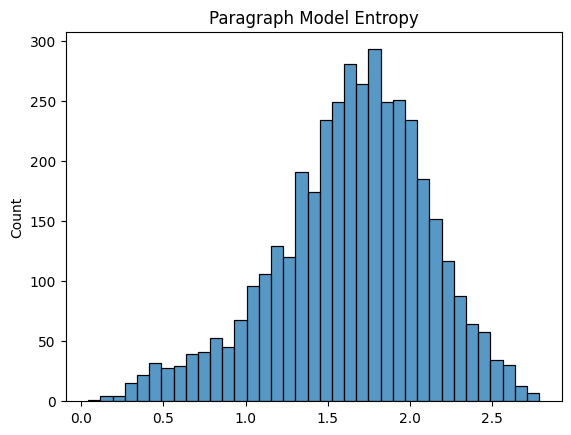

In [89]:
sns.histplot(entropy)
plt.title("Paragraph Model Entropy")
plt.show()

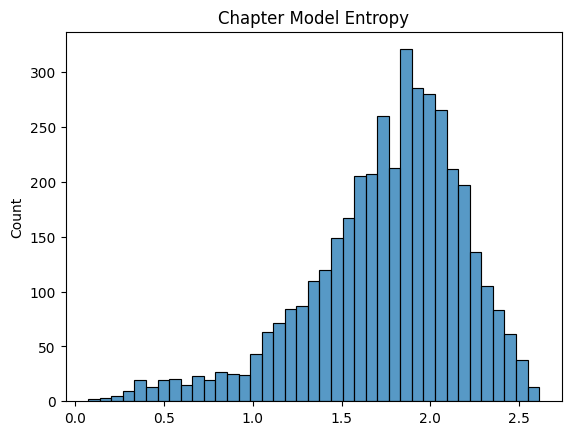

In [88]:
sns.histplot(entropy_c)
plt.title("Chapter Model Entropy")
plt.show()

It appears that the paragraph document model entropy distribution is lower than the chapter model entropy in general.

### 2.Sort the topics in each model's PHI table by topic entropy in descending order. Are the first topics in the two models about the same? In other words, do they yield similar interpretations?

In [96]:
entropy.to_frame('entropy').sort_values('entropy', ascending=False)

,entropy
term_str,
reason,2.785186
hands,2.770548
place,2.770185
minutes,2.767588
way,2.761362
...,...
dr,0.164493
rampart,0.138116
know,0.138085


In [97]:
entropy_c.to_frame('entropy_c').sort_values('entropy_c', ascending=False)

,entropy_c
term_str,
forth,2.611146
death,2.603228
lives,2.600021
fear,2.592563
grave,2.589092
...,...
ami,0.204586
launch,0.178408
tuppence,0.141986


No, we see that the two different models have different top topics with high entropy. As a result, they do not yield similar interpretations

### 3.What topic from each model is most strongly associated with each genre? Note that your answer have four parts.

In [107]:
def associated_topic(THETA):
    topics3 = {}
    for genre in LIB['genre_id'].unique():
        topics3[genre] = THETA.loc[LIB[LIB['genre_id'] == genre].index].mean().idxmax()
    return topics3

print(f"paragraph model: {associated_topic(THETA)}")
print(f"chapter model: {associated_topic(THETA_c)}")

paragraph model: {'d': 'T11', 'g': 'T10'}
chapter model: {'d': 'T01', 'g': 'T10'}


We can see that T10 is most associated with the gothic genre for both models, whereas T11 and T01 are the topics most associated with the detective genre respectively

### 4.Using the THETA table from the Chapters model, get the mean topic weights for each book. Which book is most strongly associated with the gothic genre g, based on the weight of that genre's most representative topic (as discovered in the previous question)?

In [135]:
THETA_c_genres = THETA_c.reset_index().merge(LIB.reset_index()[['book_id', 'genre_id']], on='book_id', how='left')


THETA_c_genres.reset_index().groupby(['book_id', 'genre_id']).sum().iloc[:, 2:].mean(axis=1).sort_values(ascending=False).head(1)

book_id  genre_id
udolpho  g           2.85
dtype: float64

The book most associated with the gothic genre is Udolpho

### 5.How would you characterize the subject matter of the two genres based on their topic models? Consider the words associated with the dominant topics from each model, but also the models overall.

Detective genre:

In [143]:
PHI.loc['T11'].nlargest(7)

term_str
lady        274.983311
business    199.550071
right       188.345697
matter      164.018505
things      138.384200
years       134.472541
mind        126.842663
Name: T11, dtype: float64

In [144]:
PHI.loc['T01'].nlargest(7)

term_str
yes       676.605430
oh        423.182329
father    289.463296
good      144.867072
ah        134.824644
man       134.602039
child     131.759456
Name: T01, dtype: float64

Gothic genre:

In [141]:
PHI.loc['T10'].nlargest(7)

term_str
mind     301.708298
day      202.957130
night    165.136368
hour     154.804071
hope     151.783386
steps    131.884725
time     124.084483
Name: T10, dtype: float64

In [142]:
PHI_c.loc['T10'].nlargest(7)

term_str
time       257.078311
heart      203.006853
friend     187.664125
family     161.686605
brother    158.124586
moment     158.111128
room       157.680791
Name: T10, dtype: float64

We can see that both genres and topic models are heavily characterized by themes of family and relationships. However, we can see that the gothic genre is also defined by times such as night, and themes such as hope. In contrast, the detective genre is defined a bit more ambiguously and mysteriously with words such as business, matter, and things, which also makes sense in the context of the genre.